# Preliminary EDA

In [1]:
# Suppress native-hadoop warning
!sed -i '$a\# Add the line for suppressing the NativeCodeLoader warning \nlog4j.logger.org.apache.hadoop.util.NativeCodeLoader=ERROR,console' /$HADOOP_HOME/etc/hadoop/log4j.properties

In [2]:
import sys
sys.path.append('/home/work')
BASE_DIR = '/home/work'

In [31]:
import pyspark
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import split, col, count, desc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from data.utils.data_loader import load_file_from_hdfs

In [5]:
conf = pyspark.SparkConf()
settings = conf.getAll()

# Set Spark Settings
conf = pyspark.SparkConf().setAll([
('spark.master', 'local[4]'),
('spark.app.name', 'MusicRecommender'),
('spark.driver.memory','14g')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# Print the Spark Session settings
settings = spark.sparkContext.getConf().getAll()
for s in settings:
    print(s)

('spark.sql.warehouse.dir', 'file:/home/work/Project/repo/scalable-music-recommender/spark-warehouse')
('spark.master', 'local[4]')
('spark.app.id', 'local-1716881047831')
('spark.driver.port', '34753')
('spark.app.name', 'App Name')
('spark.executor.id', 'driver')
('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAM

song_ratings_file_path = "/raw/train/train_0.txt"
song_ratings = load_file_from_hdfs(song_ratings_file_path)

In [41]:
song_attributes_file_path = "song-attributes.txt"
#song_attributes = load_file_from_hdfs(song_attributes_file_path)
song_attributes = spark.read.text("file:///home/work/Project/yahoo_dataset/song-attributes.txt").cache()

genre_hierarchy_file_path = "genre-hierarchy.txt"
#genre_hierarchy = load_file_from_hdfs(genre_hierarchy_file_path)
genre_hierarchy = spark.read.text("file:///home/work/Project/yahoo_dataset/genre-hierarchy.txt").cache()

In [42]:
def cleaned_df(song_ratings, song_attributes, genre_hierarchy):
    song_ratings = song_ratings.withColumnRenamed("_c0", "user_id") \
        .withColumnRenamed("_c1", "song_id") \
        .withColumnRenamed("_c2", "rating") 
    song_attributes = song_attributes.withColumn("song_id", split(song_attributes.value, "\t")[0]) \
       .withColumn("album_id", split(song_attributes.value, "\t")[1]) \
       .withColumn("artist_id", split(song_attributes.value, "\t")[2]) \
       .withColumn("genre_id", split(song_attributes.value, "\t")[3]) \
       .drop("value")
    song_attributes = song_attributes.withColumn("song_id", col("song_id").cast("integer")) \
       .withColumn("album_id", col("album_id").cast("integer")) \
       .withColumn("artist_id", col("artist_id").cast("integer"))
    genre_hierarchy = genre_hierarchy.withColumn("genre_id", split(genre_hierarchy.value, "\t")[0]) \
       .withColumn("parent_genre_id", split(genre_hierarchy.value, "\t")[1]) \
       .withColumn("level", split(genre_hierarchy.value, "\t")[2]) \
       .withColumn("genre_name", split(genre_hierarchy.value, "\t")[3]) \
       .drop("value")
    genre_hierarchy = genre_hierarchy.withColumn("genre_id", col("genre_id").cast("integer")) \
       .withColumn("parent_genre_id", col("parent_genre_id").cast("integer")) \
       .withColumn("level", col("level").cast("integer"))

    df = song_ratings.join(song_attributes, "song_id", how="inner")
    df = df.join(genre_hierarchy,"genre_id", how="inner")

    df = df.drop('parent_genre_id').drop('level')
    df.describe().show()

    null_columns = {column: df.filter(col(column).isNull()).count() for column in df.columns}
    null_columns
    
    return df
df = cleaned_df(song_ratings, song_attributes,genre_hierarchy)

+-------+-----------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+
|summary|         genre_id|          song_id|           user_id|            rating|          album_id|        artist_id|       genre_name|
+-------+-----------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+
|  count|         76344627|         76344627|          76344627|          76344627|          76344627|         76344627|         76344627|
|   mean|16.77831798169634|68279.70831871378|100040.94482474844|3.1534895834909245|10362.502501191078|4776.541211367763|             NULL|
| stddev|43.07284877305525|39461.31233820892|57753.049739694885|1.5995359813629222| 5905.052390982921|2681.146670597712|             NULL|
|    min|                0|                0|                 0|                 1|                 0|                0|Adult Alternative|
|    max|               88|

In [66]:
df.count()

76344627

In [43]:
# get users rating count 
user_ratings_count = df.groupBy("user_id").count()
user_ratings_count = user_ratings_count.withColumnRenamed("count", "ratings_count")
user_ratings_count.show()

+-------+-------------+
|user_id|ratings_count|
+-------+-------------+
|    148|          205|
|    463|          335|
|    471|          329|
|    496|          314|
|    833|          136|
|   1088|         1254|
|   1238|          129|
|   1342|           77|
|   1580|         1213|
|   1591|           88|
|   1645|           28|
|   1829|          193|
|   1959|          647|
|   2122|           22|
|   2142|          204|
|   2366|          123|
|   2659|           70|
|   2866|         1332|
|   3175|           40|
|   3749|          111|
+-------+-------------+
only showing top 20 rows



In [44]:
from pyspark.sql.functions import min,max
min_max_values = user_ratings_count.select(min("ratings_count").alias("min_value"), max("ratings_count").alias("max_value")).first()

min_value = min_max_values["min_value"]
max_value = min_max_values["max_value"]

print("min_value", min_value, "max_value", max_value)

min_value 20 max_value 71009


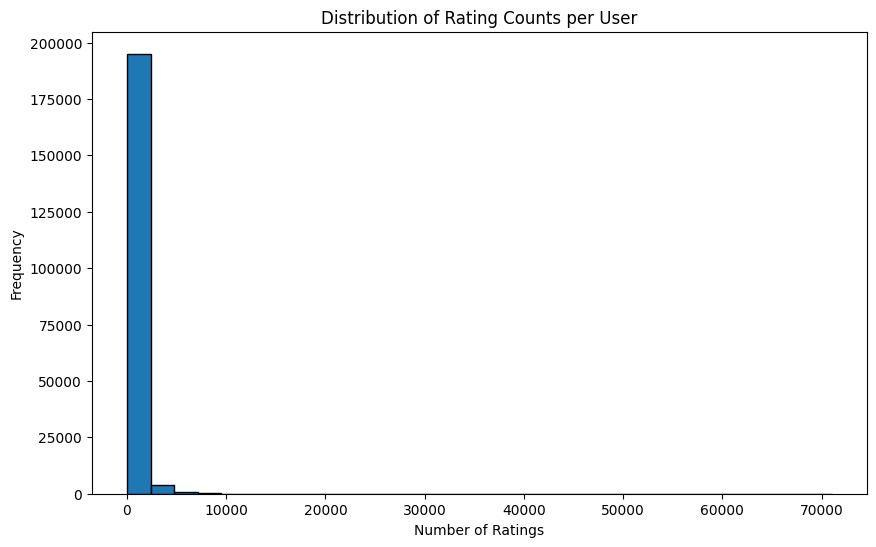

Total number of users: 200000


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

data= user_ratings_count.toPandas()

#data = user_ratings_count.select("ratings_count").rdd.flatMap(lambda x: x).collect()


plt.figure(figsize=(10, 6))
#sns.histplot(data, bins=50, kde=True)
plt.hist(data['ratings_count'], bins=30, edgecolor='black')
plt.title('Distribution of Rating Counts per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

total_users = user_ratings_count.count()
print("Total number of users:", total_users)

In [46]:
# normalization or log
# log better addresses skewness so choose log
from pyspark.sql.functions import log
user_ratings_count[user_ratings_count['ratings_count'] == 0].count() # no zero
user_ratings_count = user_ratings_count.withColumn('log_ratings_count', log(user_ratings_count['ratings_count']))  
user_ratings_count.show()

+-------+-------------+------------------+
|user_id|ratings_count| log_ratings_count|
+-------+-------------+------------------+
|    148|          205|5.3230099791384085|
|    463|          335| 5.814130531825066|
|    471|          329| 5.796057750765372|
|    496|          314| 5.749392985908253|
|    833|          136| 4.912654885736052|
|   1088|         1254| 7.134093721192866|
|   1238|          129| 4.859812404361672|
|   1342|           77| 4.343805421853684|
|   1580|         1213|  7.10085190894405|
|   1591|           88| 4.477336814478207|
|   1645|           28| 3.332204510175204|
|   1829|          193| 5.262690188904886|
|   1959|          647| 6.472346294500901|
|   2122|           22| 3.091042453358316|
|   2142|          204| 5.318119993844216|
|   2366|          123| 4.812184355372417|
|   2659|           70| 4.248495242049359|
|   2866|         1332| 7.194436851100335|
|   3175|           40|3.6888794541139363|
|   3749|          111| 4.709530201312334|
+-------+--

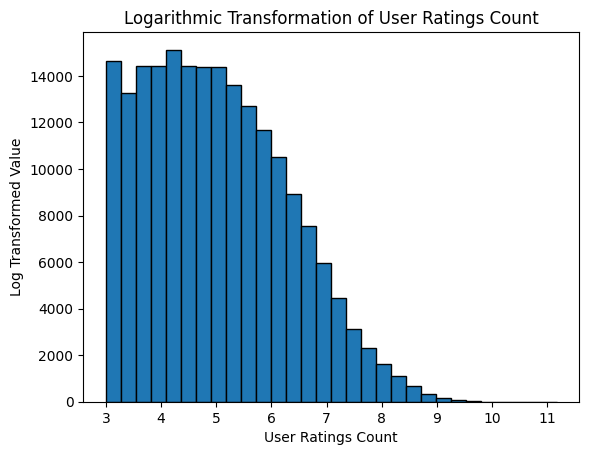

In [47]:
import matplotlib.pyplot as plt

user_ratings_count_p = user_ratings_count.toPandas()

plt.hist(user_ratings_count_p['log_ratings_count'], bins=30, edgecolor='black')
plt.title('Logarithmic Transformation of User Ratings Count')
plt.xlabel('User Ratings Count')
plt.ylabel('Log Transformed Value')
plt.show()

In [71]:
from pyspark.sql.functions import log, col, abs, mean, stddev

mean_log = user_ratings_count.select(mean(col("log_ratings_count"))).collect()[0][0]
stddev_log = user_ratings_count.select(stddev(col("log_ratings_count"))).collect()[0][0]

user_ratings_count = user_ratings_count.withColumn("z_score", (col("log_ratings_count") - mean_log) / stddev_log)
user_ratings_count = user_ratings_count.withColumn("is_outlier", abs(col("z_score")) > 3) # threshold 3


In [72]:
user_ratings_count_cleaned = user_ratings_count.filter(col("is_outlier") == False)
print("Original DataFrame:", user_ratings_count.count())
print("Cleaned DataFrame (without outliers):", user_ratings_count_cleaned.count())

Original DataFrame: 200000


Cleaned DataFrame (without outliers): 199620


In [57]:
user_ratings_count_cleaned_df = df.join(user_ratings_count_cleaned.select("user_id"), on="user_id", how="inner")
user_ratings_count_cleaned_df.show()

+-------+--------+-------+------+--------+---------+----------+
|user_id|genre_id|song_id|rating|album_id|artist_id|genre_name|
+-------+--------+-------+------+--------+---------+----------+
|    148|       0|     41|     5|   11089|       43|   Unknown|
|    148|     134|    155|     4|   12051|     8021|      Rock|
|    148|       0|    266|     2|    2406|     2450|   Unknown|
|    148|       0|   1955|     5|   13388|     4777|   Unknown|
|    148|       0|   2263|     5|    3079|      950|   Unknown|
|    148|       0|   4462|     5|    6434|     9302|   Unknown|
|    148|       0|   4607|     5|   10099|     5495|   Unknown|
|    148|     114|   5236|     5|    2454|     9165|       R&B|
|    148|       0|   7386|     5|    6815|     5495|   Unknown|
|    148|       0|   7421|     5|   14130|      862|   Unknown|
|    148|       0|   7464|     4|    7169|     2105|   Unknown|
|    148|       0|   8024|     4|    1057|     6573|   Unknown|
|    148|       0|   9269|     3|   1770

In [61]:
user_ratings_count_cleaned_df.count()

72503130

In [58]:
## IQR way instead of log

In [67]:
quantiles = user_ratings_count.approxQuantile("ratings_count", [0.25, 0.75], 0.05)
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

filtered_df = user_ratings_count.filter((col("ratings_count") >= lower_bound) & (col("ratings_count") <= upper_bound))

print("Data without Outliers:", filtered_df.count())

Data without Outliers: 172917


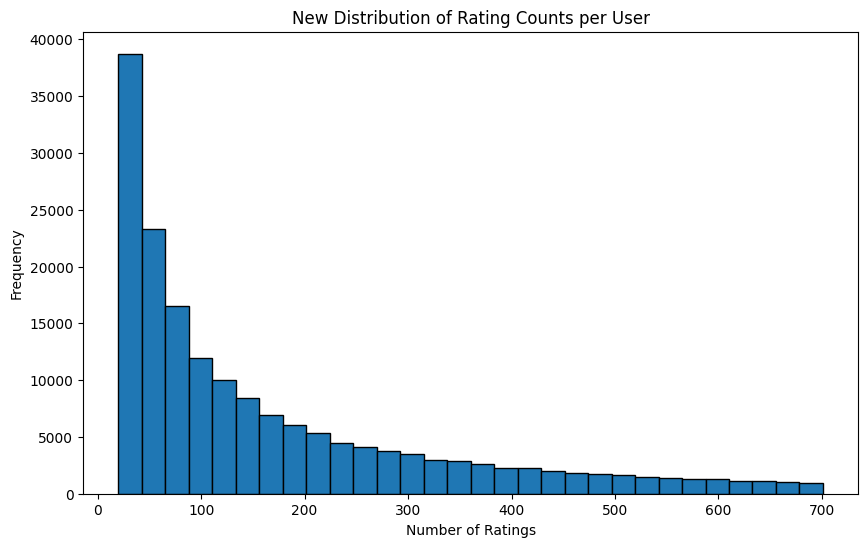

In [68]:
filtered_df_data= filtered_df.toPandas()

plt.figure(figsize=(10, 6))
#sns.histplot(data, bins=50, kde=True)
plt.hist(filtered_df_data['ratings_count'], bins=30, edgecolor='black')
plt.title('New Distribution of Rating Counts per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

In [70]:
filtered_df_new = df.join(filtered_df.select("user_id"), on="user_id", how="inner")
print("new dataset count", filtered_df_new.count())

new dataset count 29011014


In [48]:
# remove users instead?

In [63]:
# 0 - 800 reviews in first two bin
#new_filtered = user_ratings_count.filter(user_ratings_count['ratings_count'] <= 800)
#new_filtered.count()

In [64]:
#final_filtered_df = df.join(new_filtered.select("user_id"), on="user_id", how="inner")

In [65]:
#final_filtered_df.show()